## Feature selection 

### import libraries


In [1171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif, RFE, SequentialFeatureSelector
from sklearn_genetic import GAFeatureSelectionCV
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from xgboost import XGBRegressor


from sklearn.metrics import r2_score, mean_squared_error, accuracy_score,  mean_absolute_error

In [1172]:
# Load datasets
players_2024_clean = pd.read_csv('Fifa24PLayers_beforefss.csv')
players_2024_clean

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_attacking,work_rate_defending
0,91,94,181500000.0,230000.0,24,182,75,73.0,16.0,1.0,...,63,68,63,54,54,54,63,18,2,0
1,91,94,185000000.0,340000.0,22,195,94,10.0,13.0,1.0,...,63,62,60,62,62,62,60,19,2,1
2,91,91,103000000.0,350000.0,32,181,75,10.0,13.0,1.0,...,80,79,75,70,70,70,75,21,2,1
3,90,90,41000000.0,23000.0,36,169,67,112893.0,39.0,1.0,...,63,64,59,49,49,49,59,19,0,0
4,90,90,51000000.0,95000.0,35,185,81,607.0,350.0,1.0,...,64,64,60,55,55,55,60,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,47,57,100000.0,500.0,20,176,76,114168.0,2149.0,1.0,...,39,41,43,47,47,47,43,13,1,1
18346,47,55,100000.0,1000.0,21,183,74,114628.0,2012.0,1.0,...,43,44,46,47,47,47,46,13,1,1
18347,47,55,100000.0,2000.0,19,184,65,111724.0,2012.0,1.0,...,31,35,33,27,27,27,33,13,1,0
18348,47,54,90000.0,1000.0,21,178,74,112163.0,2012.0,1.0,...,45,45,45,44,44,44,45,14,1,1


### splitting the data into a train and a test data

In [1173]:
X = players_2024_clean.drop("overall", axis=1)
y= players_2024_clean["overall"]

#split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


We now have a training a test datset ready to to build a model. However, we have a lot of features so we will likely have an overfit model as it stands. Therefore we will need to reduce our number of features.



### Correlation Analysis within Player Positions

In our dataset, certain features within player positions exhibit correlation. To enhance the simplicity and effectiveness of our model, we will perform feature selection by retaining only one attribute from correlated sets.

This approach ensures that we include diverse yet representative features within each player position category.

In [1174]:
cols = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
X_train[cols].corr()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
ls,1.000000,1.000000,1.000000,0.974399,0.988061,0.988061,0.988061,0.974399,0.973180,0.973180,...,0.660980,0.660980,0.660980,0.732533,0.670430,0.522707,0.522707,0.522707,0.670430,-0.727923
st,1.000000,1.000000,1.000000,0.974399,0.988061,0.988061,0.988061,0.974399,0.973180,0.973180,...,0.660980,0.660980,0.660980,0.732533,0.670430,0.522707,0.522707,0.522707,0.670430,-0.727923
rs,1.000000,1.000000,1.000000,0.974399,0.988061,0.988061,0.988061,0.974399,0.973180,0.973180,...,0.660980,0.660980,0.660980,0.732533,0.670430,0.522707,0.522707,0.522707,0.670430,-0.727923
lw,0.974399,0.974399,0.974399,1.000000,0.994511,0.994511,0.994511,1.000000,0.992717,0.992717,...,0.685493,0.685493,0.685493,0.776515,0.709166,0.525732,0.525732,0.525732,0.709166,-0.741937
lf,0.988061,0.988061,0.988061,0.994511,1.000000,1.000000,1.000000,0.994511,0.994753,0.994753,...,0.675174,0.675174,0.675174,0.754267,0.686987,0.515621,0.515621,0.515621,0.686987,-0.720889
cf,0.988061,0.988061,0.988061,0.994511,1.000000,1.000000,1.000000,0.994511,0.994753,0.994753,...,0.675174,0.675174,0.675174,0.754267,0.686987,0.515621,0.515621,0.515621,0.686987,-0.720889
rf,0.988061,0.988061,0.988061,0.994511,1.000000,1.000000,1.000000,0.994511,0.994753,0.994753,...,0.675174,0.675174,0.675174,0.754267,0.686987,0.515621,0.515621,0.515621,0.686987,-0.720889
rw,0.974399,0.974399,0.974399,1.000000,0.994511,0.994511,0.994511,1.000000,0.992717,0.992717,...,0.685493,0.685493,0.685493,0.776515,0.709166,0.525732,0.525732,0.525732,0.709166,-0.741937
lam,0.973180,0.973180,0.973180,0.992717,0.994753,0.994753,0.994753,0.992717,1.000000,1.000000,...,0.713253,0.713253,0.713253,0.783874,0.718137,0.547958,0.547958,0.547958,0.718137,-0.716882
cam,0.973180,0.973180,0.973180,0.992717,0.994753,0.994753,0.994753,0.992717,1.000000,1.000000,...,0.713253,0.713253,0.713253,0.783874,0.718137,0.547958,0.547958,0.547958,0.718137,-0.716882


In [1175]:
similar_cols = ["ls","rs","lf","rf","lam","ram","lcm","rcm","ldm","rdm","lcb","rcb","rwb","lwb","lw","cf","rw" ,"lm","lb","cam","cdm" ]
new_cols = [ col for col in cols if col not in similar_cols  ]
X_train[new_cols].corr()
# delete similar cols 
X_train = X_train.drop(columns = similar_cols)

In [1176]:
X_train

,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
7255,81,2400000.0,2000.0,21,172,66,1887.0,308.0,1.0,15,...,10,15.0,54,62,63,61,64,17,1,2
10241,66,750000.0,3000.0,27,171,72,112965.0,353.0,1.0,10,...,12,15.0,54,54,58,61,63,15,2,1
5100,70,1500000.0,7000.0,27,189,84,111052.0,7.0,1.0,6,...,8,15.0,61,67,61,69,63,19,1,1
4371,80,3500000.0,11000.0,20,180,70,1750.0,4.0,1.0,11,...,12,15.0,64,68,69,66,69,16,2,1
11204,69,800000.0,2000.0,25,180,78,1862.0,189.0,1.0,10,...,10,15.0,55,59,62,57,62,16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,67,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,...,10,15.0,64,59,65,43,50,15,2,1
11964,74,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,...,9,15.0,51,55,58,59,61,15,2,1
5390,76,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,...,8,15.0,56,62,61,69,67,15,1,1
860,85,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,...,15,15.0,71,68,75,47,55,18,1,0


In [1177]:
cols = ['pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']
corr_matrix = X_train.loc[: , cols].corr() 
corr_matrix[corr_matrix > 0.9 ]

,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
pace,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shooting,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.980385,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passing,NaN,NaN,1.000000,0.934939,NaN,NaN,0.91324,NaN,NaN,0.936564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbling,NaN,NaN,0.934939,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
defending,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,0.978570,0.985190,0.975444,NaN,NaN,NaN,NaN,NaN,NaN
physic,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_crossing,NaN,NaN,0.913240,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_finishing,NaN,0.980385,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_heading_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_short_passing,NaN,NaN,0.936564,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1178]:
X_train.columns

Index(['potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'league_id', 'league_level', 'club_position',
       'club_jersey_number', 'club_joined_date',
       'club_contract_valid_until_year', 'nationality_id', 'preferred_foot',
       'weak_foot', 'skill_moves', 'international_reputation', 'body_type',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_posi

In [1179]:
correlated_cols = [ "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle", "skill_dribbling",
                   "attacking_finishing","power_long_shots","movement_acceleration","movement_sprint_speed","mentality_interceptions","skill_ball_control"]
new_cols = [col for col in cols if col not in correlated_cols]
corr_matrix = X_train.loc[: , new_cols].corr() 
corr_matrix[corr_matrix > 0.9]
# drop columns correlated_cols and "potential"
X_train = X_train.drop(columns = correlated_cols + ["potential"])

### dropping release_clause_eur
we drop release_clause_eur since it is correlated with value_eur

In [1180]:
X_train

,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
7255,2400000.0,2000.0,21,172,66,1887.0,308.0,1.0,15,28.0,...,10,15.0,54,62,63,61,64,17,1,2
10241,750000.0,3000.0,27,171,72,112965.0,353.0,1.0,10,32.0,...,12,15.0,54,54,58,61,63,15,2,1
5100,1500000.0,7000.0,27,189,84,111052.0,7.0,1.0,6,74.0,...,8,15.0,61,67,61,69,63,19,1,1
4371,3500000.0,11000.0,20,180,70,1750.0,4.0,1.0,11,41.0,...,12,15.0,64,68,69,66,69,16,2,1
11204,800000.0,2000.0,25,180,78,1862.0,189.0,1.0,10,34.0,...,10,15.0,55,59,62,57,62,16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,40.0,...,10,15.0,64,59,65,43,50,15,2,1
11964,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,36.0,...,9,15.0,51,55,58,59,61,15,2,1
5390,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,24.0,...,8,15.0,56,62,61,69,67,15,1,1
860,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,11.0,...,15,15.0,71,68,75,47,55,18,1,0


In [1181]:
other_correlated = ["release_clause_eur"] 
#drop other_correlated
X_train = X_train.drop(columns = other_correlated)
corr_matrix = X_train.iloc[: , 1 : ].corr() 
corr_matrix[corr_matrix > 0.8]

,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,club_joined_date,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
wage_eur,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_cm,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_kg,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_team_id,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
league_id,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
league_level,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_jersey_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_joined_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating the variance of the columns 

In [1182]:
for col in X_train.columns  : 
    print(f" for column {col} it has variance={X_train[col].var()}")

 for column value_eur it has variance=55365867970958.09
 for column wage_eur it has variance=342629227.4478045
 for column age it has variance=22.47190516816902
 for column height_cm it has variance=46.672351355826926
 for column weight_kg it has variance=48.311354214440115
 for column club_team_id it has variance=2940363889.765214
 for column league_id it has variance=364977.6245554574
 for column league_level it has variance=0.5784777445322113
 for column club_position it has variance=15.745171661629595
 for column club_jersey_number it has variance=344.165592498057
 for column club_joined_date it has variance=545889.22489756
 for column club_contract_valid_until_year it has variance=1.7057993580900797
 for column nationality_id it has variance=2463.2374553838818
 for column preferred_foot it has variance=0.1842275113194573
 for column weak_foot it has variance=0.46170048797493796
 for column skill_moves it has variance=0.603164366632923
 for column international_reputation it has va

In [1183]:
X_train["international_reputation"].value_counts()

international_reputation
1    10267
2      539
3      173
4       19
5       12
Name: count, dtype: int64

In [1184]:
X_train.iloc[ : , 1:].var().sort_values(ascending=False)


club_team_id                      2.940364e+09
wage_eur                          3.426292e+08
club_joined_date                  5.458892e+05
league_id                         3.649776e+05
nationality_id                    2.463237e+03
mentality_positioning             3.908552e+02
defending                         3.645058e+02
club_jersey_number                3.441656e+02
skill_curve                       3.231967e+02
attacking_crossing                3.198952e+02
goalkeeping_reflexes              3.194659e+02
attacking_volleys                 3.121785e+02
goalkeeping_diving                3.072762e+02
attacking_heading_accuracy        3.012915e+02
goalkeeping_positioning           2.914832e+02
skill_fk_accuracy                 2.870960e+02
goalkeeping_handling              2.857735e+02
shooting                          2.843549e+02
mentality_aggression              2.842147e+02
goalkeeping_kicking               2.779761e+02
power_stamina                     2.705358e+02
mentality_pen

### scaling the year 
Min Max scaling column contract valid until 


In [1185]:
X_train["club_contract_valid_until_year"] = (X_train["club_contract_valid_until_year"] -2023 )
print((X_train["club_contract_valid_until_year"].unique()))
X_train.rename(columns={"club_contract_valid_until_year" : "years_for_contract_validity" })

[4.         5.         3.         1.         2.         0.
 3.5        6.         2.5        8.         7.         1.5
 0.5        1.33333333 9.         4.5        1.66666667]


,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
7255,2400000.0,2000.0,21,172,66,1887.0,308.0,1.0,15,28.0,...,10,15.0,54,62,63,61,64,17,1,2
10241,750000.0,3000.0,27,171,72,112965.0,353.0,1.0,10,32.0,...,12,15.0,54,54,58,61,63,15,2,1
5100,1500000.0,7000.0,27,189,84,111052.0,7.0,1.0,6,74.0,...,8,15.0,61,67,61,69,63,19,1,1
4371,3500000.0,11000.0,20,180,70,1750.0,4.0,1.0,11,41.0,...,12,15.0,64,68,69,66,69,16,2,1
11204,800000.0,2000.0,25,180,78,1862.0,189.0,1.0,10,34.0,...,10,15.0,55,59,62,57,62,16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,40.0,...,10,15.0,64,59,65,43,50,15,2,1
11964,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,36.0,...,9,15.0,51,55,58,59,61,15,2,1
5390,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,24.0,...,8,15.0,56,62,61,69,67,15,1,1
860,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,11.0,...,15,15.0,71,68,75,47,55,18,1,0


### data preprocessing and scaling

To ensure uniformity and facilitate accurate model training, we'll scale our data. Scaling is crucial for machine learning algorithms, especially those sensitive to the magnitude of features. This process will bring all attributes to a comparable scale, preventing certain features from dominating the model training process.


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'value_eur'}>,
        <Axes: title={'center': 'wage_eur'}>],
       [<Axes: title={'center': 'league_id'}>,
        <Axes: title={'center': 'club_team_id'}>,
        <Axes: title={'center': 'st'}>],
       [<Axes: title={'center': 'cm'}>, <Axes: title={'center': 'rm'}>,
        <Axes: title={'center': 'cb'}>],
       [<Axes: title={'center': 'rb'}>,
        <Axes: title={'center': 'attacking_crossing'}>, <Axes: >]],
      dtype=object)

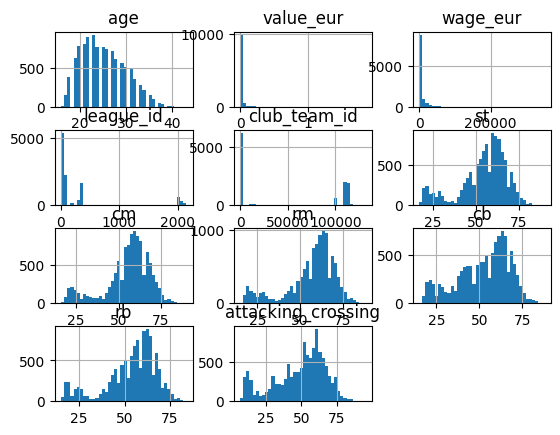

In [1186]:
X_train.loc[ : , ["age","value_eur","wage_eur","league_id","club_team_id","st","cm","rm","cb","rb","attacking_crossing"]].hist(bins=40)
# Note : ST,CM,RM,CB,RB follows approximately bell curve

### normalize and standarize 

In [1187]:
import math
normalized_cols = []
standarized_cols = ["st","cm","rm","cb","rb","value_eur","wage_eur"] # generally for attributes that have bell curve or follow a normal distribution
scaled_cols =  normalized_cols +(standarized_cols) 
for col in scaled_cols :

    min = X_train[col].min()
    max = X_train[col].max()
    mean = X_train[col].mean()
    std =  X_train[col].std()
    
    
    if col in normalized_cols : 
        X_train[col] = (X_train[col] - min)/(max - min)
        X_test[col] = (X_test[col] - min)/(max - min)

    elif col in standarized_cols : 
        X_train[col] = (X_train[col] - mean)/(std)
        X_test[col] =(X_test[col]- mean)/(std)

        




In [1188]:
X_test

,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_attacking,work_rate_defending
9353,66,-0.270057,-0.365303,29,182,74,111083.0,66.0,1.0,1,...,47,50,49,47,-0.383906,47,-0.327901,16,1,0
14446,61,-0.361445,-0.203231,31,180,79,607.0,350.0,1.0,4,...,28,27,27,25,-1.849050,25,-1.867605,60,1,1
12708,63,-0.317095,-0.203231,28,188,74,1940.0,61.0,4.0,1,...,48,52,50,47,-0.383906,47,-0.257914,13,2,1
12878,81,-0.253258,-0.432833,19,178,70,210.0,17.0,2.0,6,...,61,61,62,62,0.615055,62,0.581924,14,1,1
11198,69,-0.270057,-0.446339,22,177,71,111332.0,2019.0,1.0,12,...,60,62,62,60,0.481861,60,0.581924,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,70,-0.209580,-0.430132,32,181,82,266.0,319.0,1.0,1,...,55,55,53,52,-0.050919,52,-0.047954,16,2,2
6733,70,-0.196141,-0.095183,26,186,83,322.0,189.0,1.0,10,...,64,66,66,67,0.948043,67,0.861871,15,1,1
4600,74,-0.088626,0.607131,25,190,83,1801.0,14.0,2.0,1,...,47,48,46,44,-0.583698,44,-0.537860,17,2,1
18201,62,-0.370852,-0.435535,18,173,70,112392.0,350.0,1.0,12,...,45,48,48,48,-0.317309,48,-0.397887,14,1,1


## Reducing Number of Attributes Based on Overall Correlation

To streamline our analysis, we will reduce the number of attributes by eliminating those whose correlation with the overall rating falls below a specified threshold. This selective approach helps maintain focus on the most influential features in predicting player overall ratings.


In [1189]:
threshold = 0.2 # very low threshold 
corr_matrix = players_2024_clean.corr()
corr_with_target = corr_matrix["overall"]
cols_not_correlated = corr_with_target[ abs(corr_with_target)<=threshold ].index
cols_not_correlated

Index(['height_cm', 'weight_kg', 'league_level', 'club_position',
       'club_jersey_number', 'club_joined_date',
       'club_contract_valid_until_year', 'nationality_id', 'preferred_foot',
       'body_type', 'movement_acceleration', 'movement_balance',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'gk', 'work_rate_attacking', 'work_rate_defending'],
      dtype='object')

### dropping the columns not correllated to overall

In [1190]:
## drop columns not correlated with X_train
X_train = X_train.drop(columns = ['height_cm', 'club_position', 'preferred_foot', 'body_type',"body_type","weight_kg","league_level","club_jersey_number","club_joined_date"
           ,"club_contract_valid_until_year","movement_balance","gk"] )

In [1191]:
X_train
X_train.shape

(11010, 46)

In [1192]:
def variance_threshold_selector(X_train, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(X_train)
    return X_train.columns[selector.get_support(indices=True)]

In [1193]:
print(X_train["league_id"].var())

364977.6245554574


In [1194]:
def variance_threshold_selector(X_train, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(X_train)
    return X_train.columns[selector.get_support(indices=True)]

In [1195]:
def correlation_selector(X_train, threshold=0.8):
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [1196]:
def chi_squared_selector(X_train, y, top_k=4):
    selector = SelectKBest(y, k=top_k)
    selector.fit(X_train,selector)
    return X_train[X_train.columns[selector.get_support(indices=True)]]

In [1197]:
# Feature selection using mutual information
def mutual_info_selector(mutual_info_classif,X_train , top_k=4):
    selector = SelectKBest(mutual_info_classif, k=top_k)
    selector.fit(X_train,mutual_info_classif)
    return X_train[X_train.columns[selector.get_support(indices=True)]]

In [1198]:
def information_gain_selector(X_train, y, top_k=4):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    X_train_selected = selector.fit_transform(X_train, y)
    return X_train.columns[selector.get_support(indices=True)]

In [1199]:
correlation_selector(X_train.iloc[ : , 1 : ],0.7)

['shooting',
 'passing',
 'dribbling',
 'attacking_crossing',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'movement_agility',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'mentality_aggression',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed',
 'st',
 'cm',
 'rm',
 'cb',
 'rb']

In [1200]:
dropped = [ col for col in X_test.columns if col not in X_train.columns]
print(dropped)
X_test.drop(columns=dropped,inplace=True)
print(X_test)


['potential', 'height_cm', 'weight_kg', 'league_level', 'club_position', 'club_jersey_number', 'club_joined_date', 'club_contract_valid_until_year', 'preferred_foot', 'body_type', 'release_clause_eur', 'attacking_finishing', 'skill_dribbling', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_balance', 'power_long_shots', 'mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'ls', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'rcm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'rcb', 'gk']
       value_eur  wage_eur  age  club_team_id  league_id  nationality_id  \
9353   -0.270057 -0.365303   29      111083.0       66.0              45   
14446  -0.361445 -0.203231   31         607.0      350.0             183   
12708  -0.317095 -0.203231   28        1940.0       61.0              14   
12878  -0.253258 -0.432833   19         210.0       17.0              18   
11198

In [1201]:
X_train.head()

,value_eur,wage_eur,age,club_team_id,league_id,nationality_id,weak_foot,skill_moves,international_reputation,pace,...,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,work_rate_attacking,work_rate_defending
7255,-0.061747,-0.365303,21,1887.0,308.0,38,2,2,1,73.0,...,13,10,15.0,-0.055000,0.485045,0.451165,0.548458,0.721898,1,2
10241,-0.283496,-0.311279,27,112965.0,353.0,52,2,2,1,78.0,...,10,12,15.0,-0.055000,-0.110120,0.100548,0.548458,0.651911,2,1
5100,-0.182701,-0.095183,27,111052.0,7.0,54,3,2,1,56.0,...,11,8,15.0,0.454355,0.857023,0.310919,1.081237,0.651911,1,1
4371,0.086086,0.120914,20,1750.0,4.0,7,4,3,1,74.0,...,9,12,15.0,0.672650,0.931419,0.871906,0.881445,1.071830,2,1
11204,-0.276777,-0.365303,25,1862.0,189.0,47,3,3,1,69.0,...,13,10,15.0,0.017765,0.261858,0.381042,0.282068,0.581924,1,1


In [1202]:
X_test

,value_eur,wage_eur,age,club_team_id,league_id,nationality_id,weak_foot,skill_moves,international_reputation,pace,...,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,work_rate_attacking,work_rate_defending
9353,-0.270057,-0.365303,29,111083.0,66.0,45,3,3,1,67.0,...,11,8,15.0,0.818180,-0.035725,0.310919,-0.383906,-0.327901,1,0
14446,-0.361445,-0.203231,31,607.0,350.0,183,3,1,1,51.0,...,59,63,51.0,-2.019656,-1.895616,-1.933030,-1.849050,-1.867605,1,1
12708,-0.317095,-0.203231,28,1940.0,61.0,14,5,3,1,85.0,...,6,6,15.0,0.599885,-0.035725,0.381042,-0.383906,-0.257914,2,1
12878,-0.253258,-0.432833,19,210.0,17.0,18,3,2,1,66.0,...,10,9,15.0,0.308825,0.261858,0.240795,0.615055,0.581924,1,1
11198,-0.270057,-0.446339,22,111332.0,2019.0,61,3,2,1,69.0,...,12,11,15.0,0.236060,0.261858,0.310919,0.481861,0.581924,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,-0.209580,-0.430132,32,266.0,319.0,12,3,3,1,74.0,...,8,14,15.0,1.109240,0.633836,0.801782,-0.050919,-0.047954,2,2
6733,-0.196141,-0.095183,26,322.0,189.0,34,3,2,1,66.0,...,6,11,15.0,0.017765,0.187462,0.170672,0.948043,0.861871,1,1
4600,-0.088626,0.607131,25,1801.0,14.0,13,4,3,1,72.0,...,10,14,15.0,1.109240,0.261858,0.451165,-0.583698,-0.537860,2,1
18201,-0.370852,-0.435535,18,112392.0,350.0,183,3,2,1,66.0,...,11,10,15.0,-1.073710,-1.151660,-0.881179,-0.317309,-0.397887,1,1


In [1203]:
y_train

7255     67
10241    65
5100     70
4371     70
11204    64
         ..
11284    64
11964    63
5390     69
860      77
15795    58
Name: overall, Length: 11010, dtype: int64

In [1204]:
y_test

9353     66
14446    61
12708    63
12878    62
11198    64
         ..
4867     70
6733     68
4600     70
18201    50
16342    57
Name: overall, Length: 7340, dtype: int64

### build a model 
let's start with a RandomForestRegressor model


In [1205]:

# Create a RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, 
    max_depth=5,
)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean absolute Error: {mae}")

Mean Squared Error: 2.073005226793956
R^2 Score: 0.9544019187841483
Mean absolute Error: 1.0203469783025656


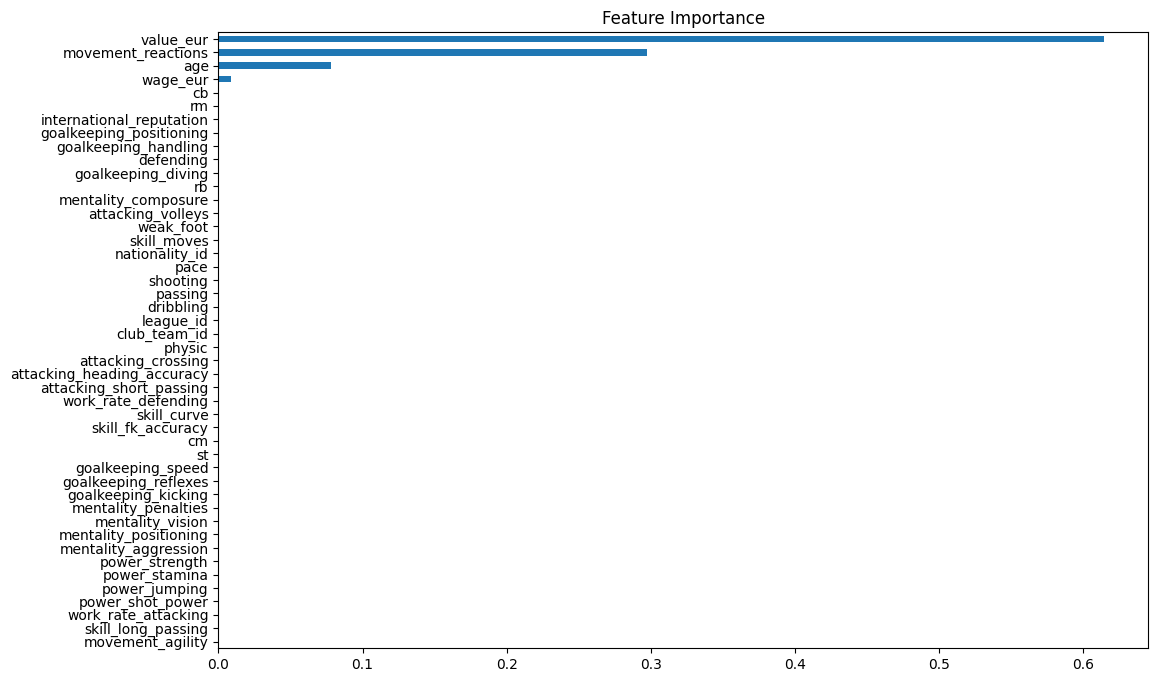

In [1206]:
# get feature importances
features_importance = pd.Series(rf_model.feature_importances_, X_train.columns)

#plotting the features
features_importance.sort_values().plot(kind="barh", figsize=(12,8));
plt.title('Feature Importance');
plt.show()


In [1207]:
scores_dict = {'Random Forest' : [r2.round(4), mse.round(2), mae.round(2)]}


we run the linear regression model 

In [1208]:

# Create a Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_linear = linear_model.predict(X_test)

# Evaluate the Linear Regression model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred)


print("Linear Regression Model:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")
print(f"Mean Absolute Error: {mae_linear}")


Linear Regression Model:
Mean Squared Error: 4.577066513630495
R^2 Score: 0.8993222747722369
Mean Absolute Error: 1.0203469783025656


In [1209]:
scores_dict['Linear Regression'] = [r2_linear.round(4), mse_linear.round(2), mse_linear.round(2)]


the X_trainGBRegressor model 

In [1211]:
# Create X_trainGBoost Regressor instance
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.001,
    reg_lambda=0.001
)

# Train the model
xgb_model.fit(X_train, y_train)

#make predictions 
y_pred = xgb_model.predict(X_test)

# evaluate the model 
mse_boost = mean_squared_error(y_test, y_pred)
r2_boost = r2_score(y_test, y_pred_linear)
mae_boost = mean_absolute_error(y_test, y_pred)


print(f'Mean Squared Error: {mse_boost}')
print(f"R^2 Score: {r2_boost}")
print(f"Mean absolute error: {mae_boost}")



Mean Squared Error: 0.6860525154017374
R^2 Score: 0.8993222747722369
Mean absolute error: 0.6187472818982699


In [1212]:
scores_dict['X_trainGBoost'] = [r2_boost.round(4), mse_boost.round(2), mae_boost.round(2)]


### comparison 
We can compare our performance metrics below:



In [1213]:
# Create a dataframe from the dictionary
scores_df = pd.DataFrame(scores_dict, index = ['r2', 'mse', 'mae'])
scores_df
     

,Random Forest,Linear Regression,X_trainGBoost
r2,0.9544,0.8993,0.8993
mse,2.0700,4.5800,0.6900
mae,1.0200,4.5800,0.6200


We can see that Random Forest slightly outperformed Linear regression and XGBoost.


### draw the training and test error rates (learning curves)

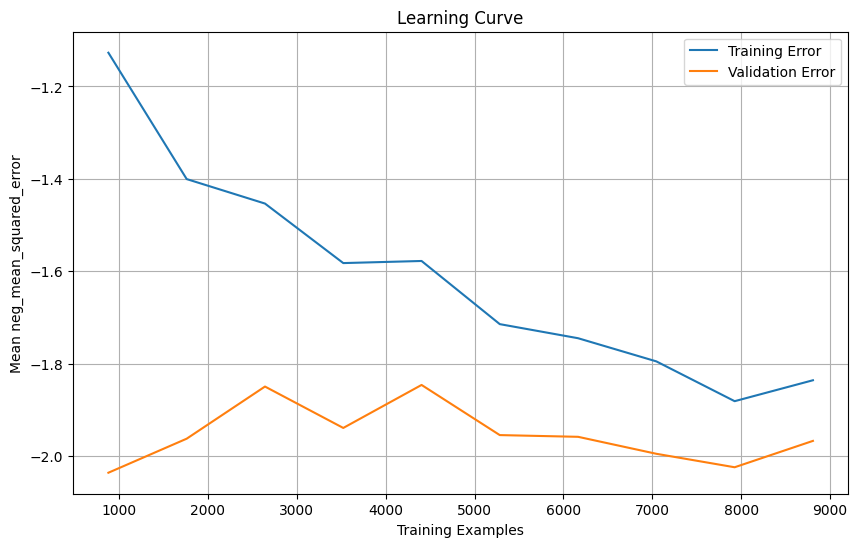

In [1215]:
def plot_learning_curve(model, X, y, scoring, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring=scoring, cv=5
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error')
    plt.plot(train_sizes, test_scores_mean, label='Validation Error')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean ' + scoring)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Assuming you have a trained model 'linear_model' and scaled data 'X_train', 'y_train'
plot_learning_curve(rf_model, X_train, y_train, scoring='neg_mean_squared_error')

- the validation error curve is consistently under the training error curve on a learning curve plot, this indicates good generalization performance of the model. Here's what it means:
    
     - A lower training error suggests that the model is able to learn from the training data effectively.
    -  The validation error, on the other hand, represents how well the model generalizes to new, unseen data. A lower validation error indicates that the model performs well on data it has not seen during training.


## Model Analysis 


We can save our model and our predicted values for further analysis:



In [1216]:
# Save a dataframe of predictions and true values
prediction_comparison = pd.DataFrame(y_pred, y_test).rename(columns={'overall' : 'True overall', 0 : 'Predicted overall'}).reset_index()
prediction_comparison.to_csv('prediction_comparison.csv', index=False)

we can do some deeper analysis into the model so identify its shortcomings and see whether any valuable insights can be gained.

We first can plot a scatter graph of out predicted results against the true values:



In [1218]:

# Load predictions
prediction_comparison = pd.read_csv(r'prediction_comparison.csv')
y_test = prediction_comparison['overall']
y_pred = prediction_comparison['Predicted overall']
     

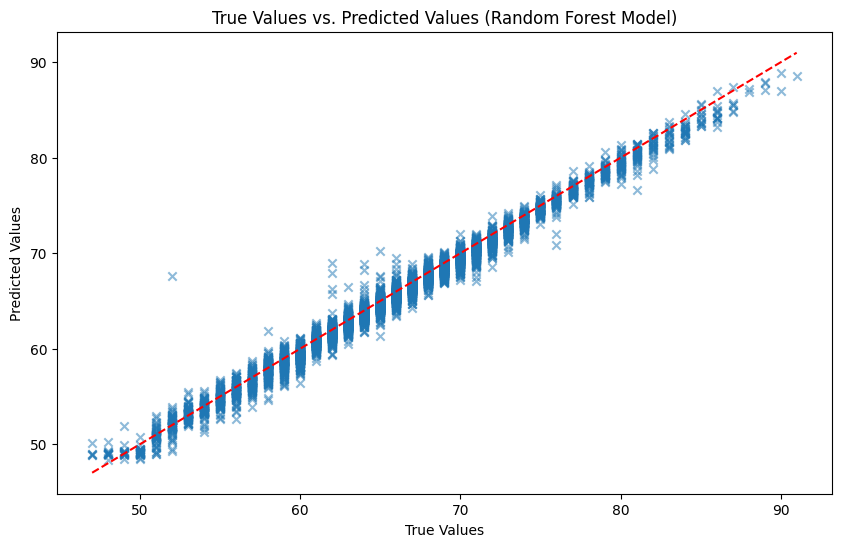

In [1219]:
# Scatter graph for the Random Forest predictions:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, marker='x', alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.set_title('True Values vs. Predicted Values (Random Forest Model)');

- The fact that the points align closely with the first diagonal indicates that the model is making accurate predictions. The predicted values are close to the true values, suggesting a good overall fit.
- The alignment along the diagonal also implies a high correlation between the predicted and true values. This is a positive indicator of the model's ability to capture the underlying patterns in the data

## Conclusion 

In conclusion, the analysis of the FIFA Ultimate Team dataset aimed at predicting player ratings using regression models has yielded positive results. The Random Forest model emerged as the top performer among the considered algorithms, achieving an impressive R² score of 0.95. This indicates a high level of accuracy and effectiveness in capturing the underlying patterns within the data.

The model not only demonstrated exceptional performance during training but also showcased robust generalization capabilities on unseen data, as evidenced by its consistent alignment with the diagonal in the scatter plot of predicted versus true values. This alignment signifies accurate predictions and a lack of systematic errors or biases in the model.

We also found that player attributes such as value euro(price), age, and movement reactions were strong predictors of player overall rating, which was to be expected given that these are generally the most sought after qualities in a player.